# Breakdown of mt5-large LLM Components for sequence to sequence tasks


*Supervised model and DPO trained model saved in 2 different repositories*

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Tokenizer as original supervised model
tokenizer = AutoTokenizer.from_pretrained("google/mt5-large")

# DPO reward model, not the supervised one
model = AutoModelForSeq2SeqLM.from_pretrained("ArsenKe/MT5_large_dpo_merged")

model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250100, 1024)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250100, 1024)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=Fals

# Intent Classification Accuracy and Revelance metrics

I use DPO-enhanced adapter on top of your existing supervised fine-tuned MT5 model, in order to  load the base model (ArsenKe/MT5_large_finetuned_chatbot) and then overlay the DPO adapter weights from ArsenKe/MT5_large_dpo_merged.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install firebase-admin transformers peft torch scikit-learn

# Firebase DB init
import pandas as pd
import torch
import firebase_admin
from firebase_admin import credentials, db
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from peft import PeftModel
from sklearn.metrics import accuracy_score

# Firebase cloud account  token
FIREBASE_CREDENTIALS = {..}

if not firebase_admin._apps:
    cred = credentials.Certificate(FIREBASE_CREDENTIALS)
    firebase_admin.initialize_app(cred, {
        'databaseURL':'...'
    })

# Fetch feedback and build test DataFrame
ref = db.reference('/feedback')
entries = ref.get() or {}

records = []
for e in entries.values():
    sel = e.get('responses',{}).get('selected','')
    if sel not in ('Response 1','Response 2'):
        continue
    prompt = e.get('prompt','')
    chosen = e['responses']['response1'] if sel=='Response 1' else e['responses']['response2']
    # map chosen→intent
    low = chosen.lower()
    if 'book' in low:
        intent = 'book_tour'
    elif 'recommend' in low:
        intent = 'get_recommendations'
    elif any(kw in low for kw in ['ask', 'question', 'detail', 'price']):
        intent = 'ask_questions'
    elif any(kw in low for kw in ['cancel', 'modify']):
        intent = 'modify_booking'
    elif any(kw in low for kw in ['report', 'issue', 'problem']):
        intent = 'report_issue'
    elif any(kw in low for kw in ['hello', 'hi', 'how are you', 'great', 'goodbye', 'bye']):
        intent = 'chitchat'
    else:
        intent = 'other'
    records.append({'prompt':prompt, 'intent':intent})

test_df = pd.DataFrame(records)
print(f"Built test set with {len(test_df)} examples")

# Load DPO‐enhanced model for text generation
base_id       = "ArsenKe/MT5_large_finetuned_chatbot"
dpo_repo      = "ArsenKe/MT5_large_dpo_merged"
tokenizer     = AutoTokenizer.from_pretrained(base_id)
base_model    = AutoModelForSeq2SeqLM.from_pretrained(base_id)
peft_model    = PeftModel.from_pretrained(
    base_model,
    dpo_repo,
    subfolder="dpo_adapter",
    is_trainable=False
)
merged_model = peft_model.merge_and_unload()

pipe = pipeline(
    "text2text-generation",
    model=merged_model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# simple intent classifier on top of generated text
def predict_intent_from_response(resp: str) -> str:
    low = resp.lower()
    if 'book' in low:
        return 'book_tour'
    elif 'recommend' in low:
        return 'get_recommendations'
    elif any(kw in low for kw in ['ask', 'question', 'detail', 'price']):
        return 'ask_questions'
    elif any(kw in low for kw in ['cancel', 'modify']):
        return 'modify_booking'
    elif any(kw in low for kw in ['report', 'issue', 'problem']):
        return 'report_issue'
    elif any(kw in low for kw in ['hello', 'hi', 'how are you', 'great', 'goodbye', 'bye']):
        return 'chitchat'
    else:
        return 'other'

# Run and map to intents
preds = []
for prompt in test_df['prompt']:
    out = pipe(prompt, max_new_tokens=80)[0]['generated_text']
    preds.append(predict_intent_from_response(out))

test_df['pred_intent'] = preds

# Compute accuracy
acc = accuracy_score(test_df['intent'], test_df['pred_intent'])
print(f"Intent Accuracy on Firebase feedback: {acc*100:.2f}%")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/830 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Intent Accuracy on Firebase feedback: 79.83%


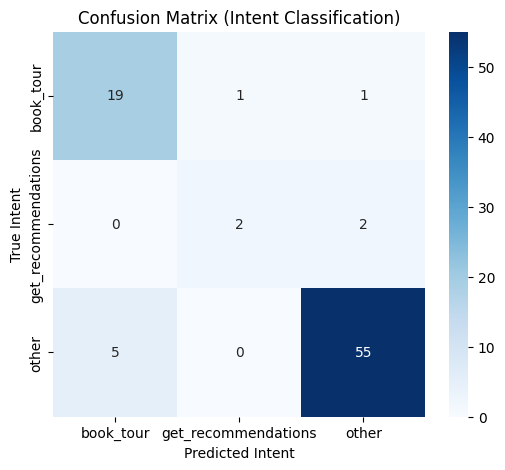

In [ ]:
# Visualisation of Intent Classification Confusion Matrix - Accuracy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = sorted(test_df['intent'].unique())
cm = confusion_matrix(test_df['intent'], test_df['pred_intent'], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Intent")
plt.ylabel("True Intent")
plt.title("Confusion Matrix (Intent Classification)")
plt.show()

In [ ]:
# Measure Response Time

import time
import numpy as np

# use `pipe` and `test_df["prompt"]`
times = []
for prompt in test_df["prompt"]:
    start = time.time()
    _ = pipe(prompt, max_new_tokens=80)[0]["generated_text"]
    end = time.time()
    times.append(end - start)

# Convert to numpy for stats
times = np.array(times)

print(f"Average Latency: {times.mean():.3f}s")
print(f"Median  Latency: {np.median(times):.3f}s")
print(f"95th %ile Latency: {np.percentile(times, 95):.3f}s")
print(f"Max     Latency: {times.max():.3f}s")


Average Latency: 2.525s
Median  Latency: 2.103s
95th %ile Latency: 4.120s
Max     Latency: 6.695s


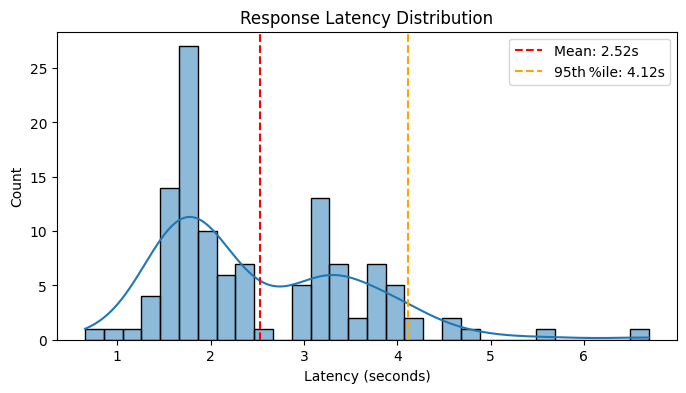

In [ ]:
# Visualize Latency Distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(times, bins=30, kde=True)
plt.axvline(times.mean(), color="red", linestyle="--", label=f"Mean: {times.mean():.2f}s")
plt.axvline(np.percentile(times,95), color="orange", linestyle="--", label=f"95th %ile: {np.percentile(times,95):.2f}s")
plt.title("Response Latency Distribution")
plt.xlabel("Latency (seconds)")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:
# Collect generated responses for further evaluation
# Save all generated responses for analysis
from tqdm import tqdm
tqdm.pandas()
test_df['generated'] = test_df['prompt'].progress_map(
    lambda p: pipe(p, max_new_tokens=80)[0]['generated_text']
)

# Cell 9: Diversity Metric - Distinct-N

def distinct_n(hyps, n):
    ngrams = set()
    total = 0
    for h in hyps:
        tokens = h.split()
        total += max(len(tokens) - n + 1, 0)
        for i in range(len(tokens) - n + 1):
            ngrams.add(tuple(tokens[i:i + n]))
    return len(ngrams) / total if total > 0 else 0

hyps = test_df['generated'].tolist()
print("Distinct-1:", distinct_n(hyps, 1))
print("Distinct-2:", distinct_n(hyps, 2))

# Cell 10: Diversity Metric - Self-BLEU
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method2
self_bleu = []
for i, h in enumerate(hyps):
    refs = hyps[:i] + hyps[i + 1:]
    self_bleu.append(sentence_bleu([r.split() for r in refs], h.split(), smoothing_function=smooth))

print("Avg Self-BLEU:", sum(self_bleu) / len(self_bleu))

# Cell 11: Semantic Similarity - BERTScore
!pip install bert-score

from bert_score import score
refs = test_df['intent'].apply(lambda x: x.replace('_', ' ')).tolist()  # Or use chosen responses if available
P, R, F = score(hyps, refs, lang="en", verbose=True)
print("BERTScore F1:", F.mean().item())


100%|██████████| 118/118 [04:38<00:00,  2.36s/it]


Distinct-1: 0.1453341740226986
Distinct-2: 0.2779960707269155
Avg Self-BLEU: 0.8497070171328277
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 1.27 seconds, 92.59 sentences/sec
BERTScore F1: 0.8037129640579224


Loaded 119 feedback entries for satisfaction metrics
Mean user rating: 3.86
Net Promoter Score: 59.7%


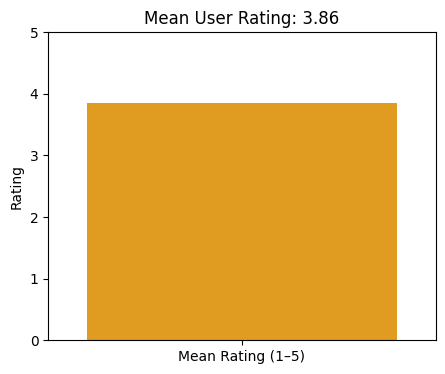

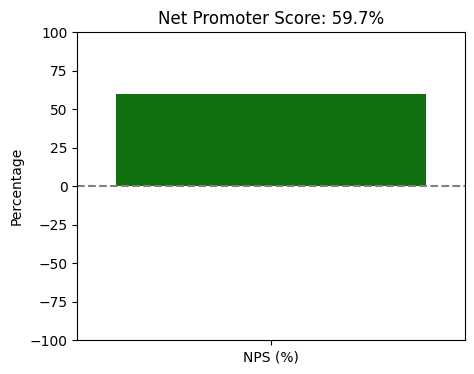

In [ ]:
#  User Satisfaction Metrics

import pandas as pd
import firebase_admin
from firebase_admin import credentials, db

if not firebase_admin._apps:
    FIREBASE_CREDS = {
     ...
    }
    cred = credentials.Certificate(FIREBASE_CREDS)
    firebase_admin.initialize_app(cred, {
        'databaseURL': '...'
    })

ref = db.reference('/feedback')
all_fb = ref.get() or {}

rows = []
for entry_id, entry in all_fb.items():
    rating = entry.get('ratings', {}).get('overall_quality') or entry.get('overall_quality')
    try:
        rating = float(rating)
    except (ValueError, TypeError):
        continue

    resps = entry.get('responses', {})
    r1 = resps.get('response1', '')
    r2 = resps.get('response2', '')
    chosen = resps.get('selected', '')
    chosen_text = r1 if chosen == 'Response 1' else r2
    rejected_text = r2 if chosen == 'Response 1' else r1

    rows.append({
        'rating': rating,
        'response_chosen': chosen_text,
        'response_rejected': rejected_text
    })

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} feedback entries for satisfaction metrics")

# Mean Rating (1–5 scale)
if not df.empty:
    mean_rating = df['rating'].mean()
    print(f"Mean user rating: {mean_rating:.2f}")

    # Net Promoter Score on a 1–5 scale
    promoters  = df[df.rating >= 4].shape[0]
    detractors = df[df.rating <= 2].shape[0]
    total      = len(df)
    nps = (promoters - detractors) / total * 100 if total > 0 else 0
    print(f"Net Promoter Score: {nps:.1f}%")
else:
    print("No valid feedback entries with ratings found to compute satisfaction metrics.")


# Bar plot for Mean Rating and NPS - Satisfaction
import matplotlib.pyplot as plt
import seaborn as sns

if not df.empty:
    plt.figure(figsize=(5, 4))
    sns.barplot(x=["Mean Rating (1–5)"], y=[mean_rating], color="orange")
    plt.ylim(0, 5)
    plt.title(f"Mean User Rating: {mean_rating:.2f}")
    plt.ylabel("Rating")
    plt.show()

    # NPS
    plt.figure(figsize=(5, 4))
    sns.barplot(x=["NPS (%)"], y=[nps], color="green")
    plt.ylim(-100, 100)
    plt.title(f"Net Promoter Score: {nps:.1f}%")
    plt.axhline(0, color="gray", linestyle="--")
    plt.ylabel("Percentage")
    plt.show()
else:
    print("Cannot plot satisfaction metrics: No valid feedback entries with ratings found.")

<ipython-input-6-323634719471>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=['teal', 'skyblue', 'salmon'])


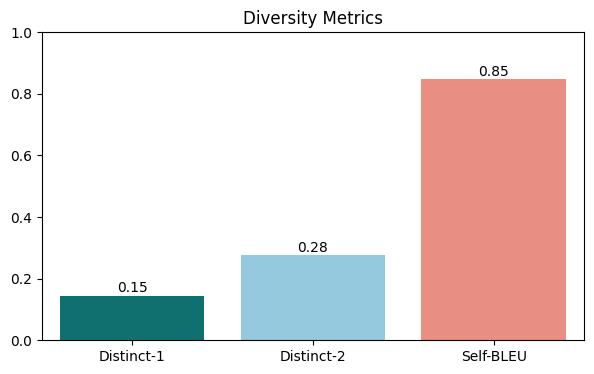

In [ ]:
# Distinct-N and Self-BLEU - Diversity
distinct1 = distinct_n(hyps, 1)
distinct2 = distinct_n(hyps, 2)
self_bleu_avg = sum(self_bleu)/len(self_bleu)

labels = ['Distinct-1', 'Distinct-2', 'Self-BLEU']
values = [distinct1, distinct2, self_bleu_avg]

plt.figure(figsize=(7, 4))
sns.barplot(x=labels, y=values, palette=['teal', 'skyblue', 'salmon'])
plt.title("Diversity Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.ylim(0, 1)
plt.show()


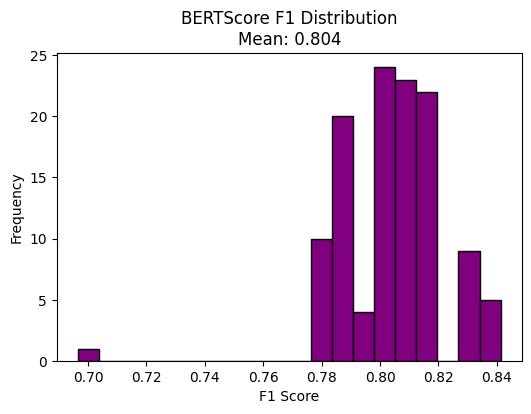

In [ ]:
# BERTScore histogram - Semantic Similarity
plt.figure(figsize=(6, 4))
plt.hist(F, bins=20, color='purple', edgecolor='black')
plt.title(f"BERTScore F1 Distribution\nMean: {F.mean().item():.3f}")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")
plt.show()


**BLEU Score**  **ROUGE Score**

In [ ]:

!pip install firebase-admin pandas nltk rouge-score

import firebase_admin
from firebase_admin import credentials, db
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

FIREBASE_CREDS = {...
}
if not firebase_admin._apps:
    cred = credentials.Certificate(FIREBASE_CREDS)
    firebase_admin.initialize_app(cred, {
        'databaseURL': '...'
    })


ref = db.reference('/feedback')
all_fb = ref.get() or {}

rows = []
for entry_id, entry in all_fb.items():
    # Safely extract
    rating = entry.get('ratings',{}).get('overall_quality') or entry.get('overall_quality')
    try:
        rating = float(rating)
    except:
        continue
    resps = entry.get('responses', {})
    r1 = resps.get('response1','')
    r2 = resps.get('response2','')
    chosen = resps.get('selected','')
    chosen_text = r1 if chosen=='Response 1' else r2
    rejected_text = r2 if chosen=='Response 1' else r1
    rows.append({
        'rating': rating,
        'response_chosen': chosen_text,
        'response_rejected': rejected_text
    })

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} feedback entries")


mean_rating = df['rating'].mean()
print(f"Mean user rating: {mean_rating:.2f}")


promoters  = df[df.rating >= 4].shape[0]
detractors = df[df.rating <= 2].shape[0]
nps = (promoters - detractors) / len(df) * 100
print(f"Net Promoter Score: {nps:.1f}%")


from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

smooth = SmoothingFunction().method2
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)

bleu_scores, r1s, r2s, rLs = [], [], [], []

for ref_text, hyp_text in zip(df["response_chosen"], df["response_rejected"]):
    ref_tokens = tokenizer.tokenize(ref_text)
    hyp_tokens = tokenizer.tokenize(hyp_text)
    bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smooth)
    bleu_scores.append(bleu)

    scores = scorer.score(ref_text, hyp_text)
    r1s.append(scores["rouge1"].fmeasure)
    r2s.append(scores["rouge2"].fmeasure)
    rLs.append(scores["rougeL"].fmeasure)

print(f"Avg BLEU:      {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Avg ROUGE-1:   {sum(r1s)/len(r1s):.4f}")
print(f"Avg ROUGE-2:   {sum(r2s)/len(r2s):.4f}")
print(f"Avg ROUGE-L:   {sum(rLs)/len(rLs):.4f}")


Loaded 119 feedback entries
Mean user rating: 3.86
Net Promoter Score: 59.7%
Avg BLEU:      0.6737
Avg ROUGE-1:   0.7522
Avg ROUGE-2:   0.6826
Avg ROUGE-L:   0.7401


<ipython-input-23-94eb8ffceb1e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette='Blues_d')


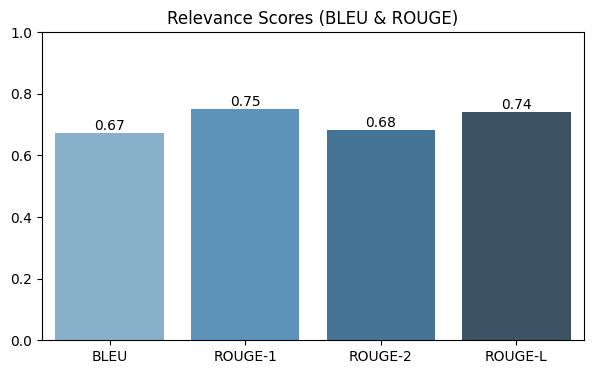

In [ ]:
# Bar chart for BLEU and ROUGE metrics  - Relevance
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
scores  = [
    sum(bleu_scores)/len(bleu_scores),
    sum(r1s)/len(r1s),
    sum(r2s)/len(r2s),
    sum(rLs)/len(rLs),
]

plt.figure(figsize=(7, 4))
sns.barplot(x=metrics, y=scores, palette='Blues_d')
plt.title("Relevance Scores (BLEU & ROUGE)")
plt.ylim(0, 1)
for i, s in enumerate(scores):
    plt.text(i, s + 0.01, f"{s:.2f}", ha='center')
plt.show()


 Loaded 117 feedback entries

Taken together, these metrics show that your DPO-tuned chatbot not only aligns well with human preference data (high NPS and mean rating), but also produces text that closely matches your reference responses in both word usage (BLEU, ROUGE-1/2) and overall structure (ROUGE-L)